In [ ]:
# Load the readr and dplyr packages
library(readr)
library(dplyr)

# Read datasets kidney_stone_data.csv into data
data <- read_csv("datasets/kidney_stone_data.csv")

# Take a look at the first few rows of the dataset
head(data)


Rows: 700 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): treatment, stone_size
dbl (1): success

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


treatment,stone_size,success
<chr>,<chr>,<dbl>
B,large,1
A,large,1
A,large,0
A,large,1
A,large,1
B,large,1


Determining which treatment had a higher success rate regardless of stone size. 

<p>From the treatment and success rate descriptive table, treatment B performed better on average compared to treatment A (82% vs. 78% success rate). 
Consider stone size in this case. To do that, we'll stratify the data into small vs. large stone subcategories and compute the same success count and rate by treatment. </p>
<p>The final table will be treatment X stone size X success.</p>

In [14]:
# Calculate number and frequency of success and failure by stone size for each treatment
sum_data <- 
  data %>% 
  group_by(treatment, stone_size, success ) %>%
  summarise(N = n()) %>%
  mutate(Freq = round(N/sum(N),3))

# Print out the data frame we just created
print(sum_data)

`summarise()` has grouped output by 'treatment', 'stone_size'. You can override
using the `.groups` argument.


# A tibble: 8 × 5
# Groups:   treatment, stone_size [4]
  treatment stone_size success     N  Freq
  <chr>     <chr>        <dbl> <int> <dbl>
1 A         large            0    71 0.27 
2 A         large            1   192 0.73 
3 A         small            0     6 0.069
4 A         small            1    81 0.931
5 B         large            0    25 0.312
6 B         large            1    55 0.688
7 B         small            0    36 0.133
8 B         small            1   234 0.867


<p>Stratified by stone size, treatment A had better results for both large and small stones compared to treatment B (i.e., 73% and 93% v.s. 69% and 87%). 
We'll use a bar plot to visualize the stone size count within each treatment. This plot will help illustrate the distribution of stone sizes within the treatments A and B. .</p>

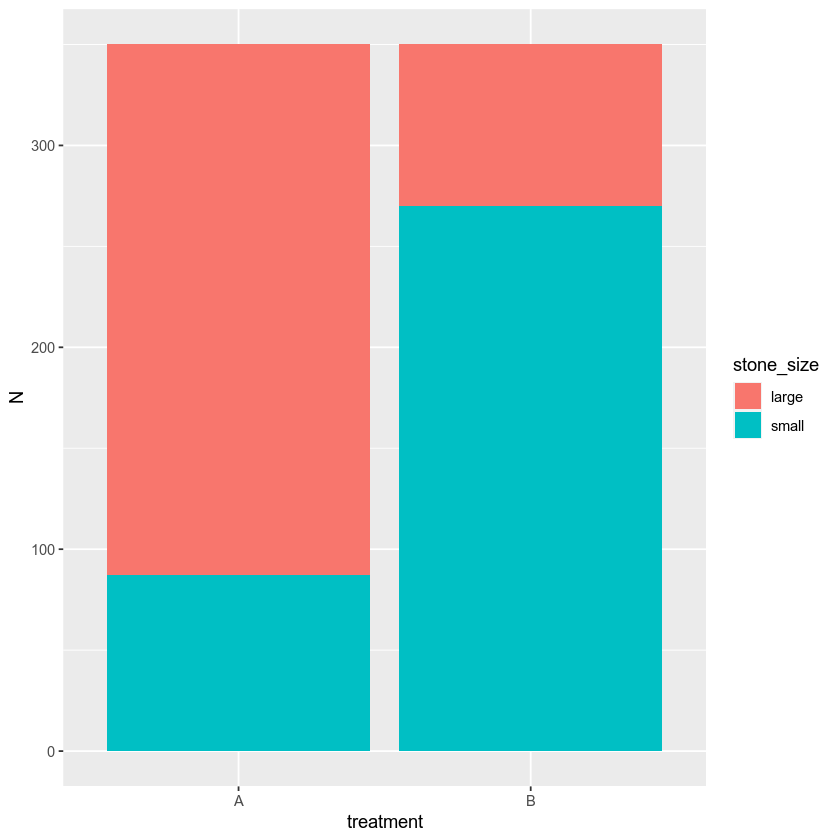

In [16]:
# Load ggplot2
library(ggplot2)

# Create a bar plot to show stone size count within each treatment
sum_data %>%
# x-axis as "treatment" and the y-axis as "N" (the count)

  ggplot(aes(x = treatment, y = N)) + 
  geom_bar(aes(fill = stone_size), stat="identity") 

From the bar plot, we noticed an unbalanced distribution of kidney stone sizes in the two treatment options. Large kidney stone cases tended to be in treatment A, while small kidney stone cases tended to be in treatment B.

## Chi-square test
<p>We'll analyze the association between stone size (i.e., case severity) and treatment assignment using a statistical test called <strong>Chi-squared</strong>. The <strong>Chi-squared</strong> test is appropriate to test associations between two categorical variables.</p>

In [ ]:
# Load the broom package 
library(broom)

# Run a Chi-squared test
trt_ss <- chisq.test(data$treatment, data$stone_size)

# Print out the result in tidy format 
tidy(trt_ss)

statistic,p.value,parameter,method
<dbl>,<dbl>,<int>,<chr>
189.3557,4.395009e-43,1,Pearson's Chi-squared test with Yates' continuity correction


The extremely small p-value indicates a highly significant difference in the distribution of stone sizes between the two treatment groups. This suggests that the type of treatment is associated with the size of the kidney stone. We can then conclude that stone size/case severity is indeed the confounding variable in this study of kidney stone treatment and success rate.

## Multiple Logistic Regression Analysis
<p>We'll use multiple logistic regression to remove the unwanted effect of stone size, and then tidy the output with a function from the broom package.</p>

In [20]:
# Run a multiple logistic regression
m <- glm(data = data, data$success ~ data$treatment + data$stone_size, family = "binomial")

# Print out model coefficient table in tidy format
tidy(m)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.0332140,0.1344695,7.683629,1.546436e-14
data$treatmentB,-0.3572287,0.2290792,-1.559411,1.188991e-01
data$stone_sizesmall,1.2605654,0.2390027,5.274272,1.332838e-07


The logistic regression analysis, modeling the success of treatments based on treatment type and stone size, produced the following results:

Intercept: The log odds of success for the baseline group (Treatment A with small stones) is estimated to be 2.294.
Treatment_encoded: The log odds of success decrease by 0.357 for Treatment B compared to Treatment A, although this effect is not statistically significant at the p < 0.05 level (p = 0.119).
Stone_size_encoded: The log odds of success decrease by 1.261 for large stones compared to small stones, which is statistically significant (p < 0.0001).

These results suggest that stone size has a significant effect on the likelihood of treatment success, with small stones being more likely to result in success than large stones, after controlling for treatment type. The difference in treatment effectiveness between Treatment A and Treatment B is not statistically significant based on this model.

## Coefficients Estimates with 95% Confidence Intervals Plot
Finally, let's plot the coefficient estimates with 95% confidence intervals to visually assess the impact of treatment type and stone size on treatment success.

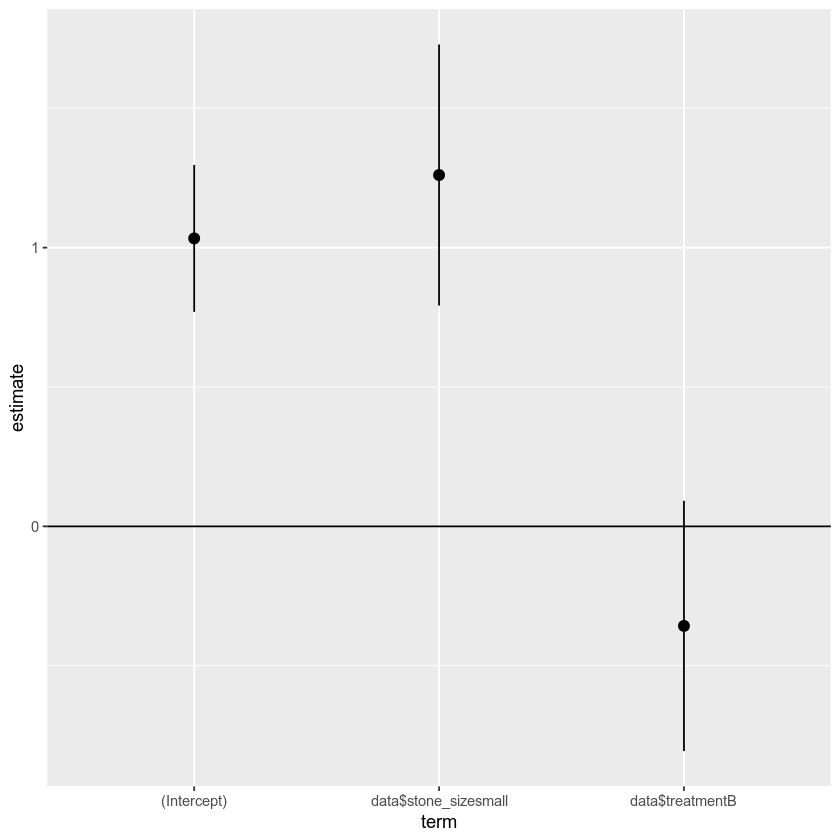

In [22]:
# Save the tidy model output into an object
tidy_m <- tidy(m)

# Plot the coefficient estimates with 95% CI for each term in the model
tidy_m %>%
  ggplot(aes(x = term, y = estimate)) + 
  geom_pointrange(aes(ymin = estimate - 1.96 * std.error, 
                      ymax = estimate + 1.96 * std.error)) +
  geom_hline(yintercept = 0)

## Insights

The insights drawn from the analysis of the kidney stone treatment dataset can be summarized as follows:

1. **Treatment Success Rates Vary by Stone Size**: The analysis showed significant differences in success rates depending on the size of the kidney stone. Small stones had higher success rates compared to large stones across treatments, which is consistent with medical expectations. The logistic regression model confirmed that stone size significantly affects treatment success, with large stones being less likely to result in a successful outcome.

2. **Comparison Between Treatments A and B**: The logistic regression analysis did not find a statistically significant difference in success rates between Treatment A and Treatment B when controlling for stone size. This suggests that, overall, neither treatment has a superior effectiveness over the other across all stone sizes. However, the lack of significance could also be due to sample size, variability in the data, or other factors not accounted for in this simple model.

3. **Statistical Association Between Treatment and Stone Size**: The Chi-squared test provided strong evidence of an association between the type of treatment administered and the size of the kidney stone. This might indicate that treatment decisions could be influenced by stone size or that certain treatments are preferred for specific stone sizes, which could have implications for clinical practice.

4. **Importance of Stone Size in Treatment Success**: The negative coefficient for stone size in the logistic regression model highlights the importance of stone size as a predictor of treatment success. This insight is crucial for medical professionals when advising patients about the expected outcomes of their treatment options.
